In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint

from numpy import mean, std, dstack

from pandas import read_csv

from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    
# Check GPU support 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5703205297795979376
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1137938446560128094
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15543657786049011079
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3079208960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5637925828977577473
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
from os import chdir as cd
cd('..')

In [3]:
from seriem_temporis.display_functions import display_block_of_values
from seriem_temporis.controller import SignalController, KasperskySetSignalController

In [4]:
signal_samples = list()
for filename in os.listdir('/media/jurgen/Новый том/Sygnaldatasets/kaspersky/attacks/')[1:3]:
    signals = KasperskySetSignalController(
        filepath='/media/jurgen/Новый том/Sygnaldatasets/kaspersky/attacks/' + filename,
        rolling_window_size=1500,
        minimal_anomaly_length=50,
        sample_rate=40,
        encoding="cp1251",
        delimiter=",",
        corr_threshold=0.9,
        smooth_method='savgol',
        generate_anomaly_mode=False,
        target_variable=55)

    signal_samples.extend(signals.get_sliced_signal)
print(len(signal_samples))

Number of columns: 60
NaN Values: False
Number of columns after clean: 55
Successfully scaled control_results
savgol filter smoothing successful
Number of columns: 60
NaN Values: False
Number of columns after clean: 55
Successfully scaled control_results
savgol filter smoothing successful
5926


In [5]:
X_data = signal_samples
shuffle(X_data)

In [6]:
train_list, test_list = train_test_split(X_data, test_size=0.33, random_state=42)
print(len(train_list))
print(len(test_list))

3970
1956


In [7]:
# Get data from Signal class into test list 
X_train = np.array([signal.values for signal in train_list])
Y_train = np.array([signal.condition_window for signal in train_list])

X_test = np.array([signal.values for signal in test_list])
Y_test = np.array([signal.condition_window for signal in test_list])

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(3970, 1500, 55)
(3970, 1500, 1)
(1956, 1500, 55)
(1956, 1500, 1)


In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 55))
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 55))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1], 1))



In [9]:
print(np.isnan(X_train).any())
print(np.isnan(Y_train).any())

False
False


In [10]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(3970, 1500, 55)
(3970, 1500, 2)
(1956, 1500, 55)
(1956, 1500, 2)


In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score
def IOU_score(y_true, y_pred):
    IOU = []
    for idx, i in tf.map_fn(enumerate(y_pred)):
        OL = 0
        UN = 0
        for _idx, result in enumerate(i):
            if result ==1 and y_true[idx,_idx]==1:
                OL += 1  
            if result ==1 or y_true[idx,_idx]==1:
                UN += 1
        if OL != 0 and UN != 0:
            IOU.append(OL/UN)
    return mean(IOU)

In [56]:
def evaluate_splitten_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1,1,128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
#     input_layer = Input(shape=(1024, 12))
    print(n_timesteps,n_features)
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
    flat1 = TimeDistributed(Flatten())(drop1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
    flat2 = TimeDistributed(Flatten())(drop2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu', padding='same')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
    flat3 = TimeDistributed(Flatten())(drop3)

    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    
    outputs = GRU(2, activation="softmax", return_sequences=True)(dense1)
#     outputs = Dense(n_outputs, activation='softmax')(dense1)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss="mse", optimizer="Adam",  metrics=['categorical_accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return model, accuracy

In [57]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# run an experiment
def run_splitten_experiment(repeats=1):
    scores = list()
    for r in range(repeats):
        model, score = evaluate_splitten_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model

# run the experiment
model_cont = run_splitten_experiment()

1500 55
Epoch 1/1
1956/1956 [==============================] - 18s 9ms/step


ValueError: not enough values to unpack (expected 4, got 2)

In [53]:
y_pred = model_cont.predict([X_test,X_test,X_test])
y_anomaly_test = Y_test[:,:,1]
y_anomaly_prediction = y_pred[:,:,1]

In [54]:
decision_threshold = 0.4
y_anomaly_prediction = (y_anomaly_prediction > decision_threshold).astype(int)

In [55]:
print(np.unique(y_anomaly_prediction, return_counts=True))
print(np.unique(y_anomaly_test, return_counts=True))
print(y_anomaly_prediction.shape)
print(y_anomaly_test.shape)

(array([0]), array([2934000]))
(array([0., 1.], dtype=float32), array([2933620,     380]))
(1956, 1500)
(1956, 1500)


In [42]:
cummulative_test = y_anomaly_test.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])
cummulative_test_pred = y_anomaly_prediction.reshape(y_anomaly_test.shape[0]*y_anomaly_test.shape[1])

In [43]:
print(cummulative_test.shape)
print(cummulative_test_pred.shape)

(2934000,)
(2934000,)


In [44]:
_f1_score = f1_score(cummulative_test, cummulative_test_pred)
_recall_score = recall_score(cummulative_test, cummulative_test_pred)
_precision_score = precision_score(cummulative_test, cummulative_test_pred)

/home/jurgen/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(_f1_score, _recall_score, _precision_score)

0.0 0.0 0.0


In [49]:
IOU = []
for idx, i in enumerate(y_anomaly_prediction):
    OL = 0
    UN = 0
    for _idx, result in enumerate(i):
        if result ==1 and y_anomaly_test[idx,_idx]==1:
            OL += 1  
        if result ==1 or y_anomaly_test[idx,_idx]==1:
            UN += 1
    if OL != 0 and UN != 0:
        IOU.append(OL/UN)

In [50]:
print(mean(IOU))

nan


/home/jurgen/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jurgen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


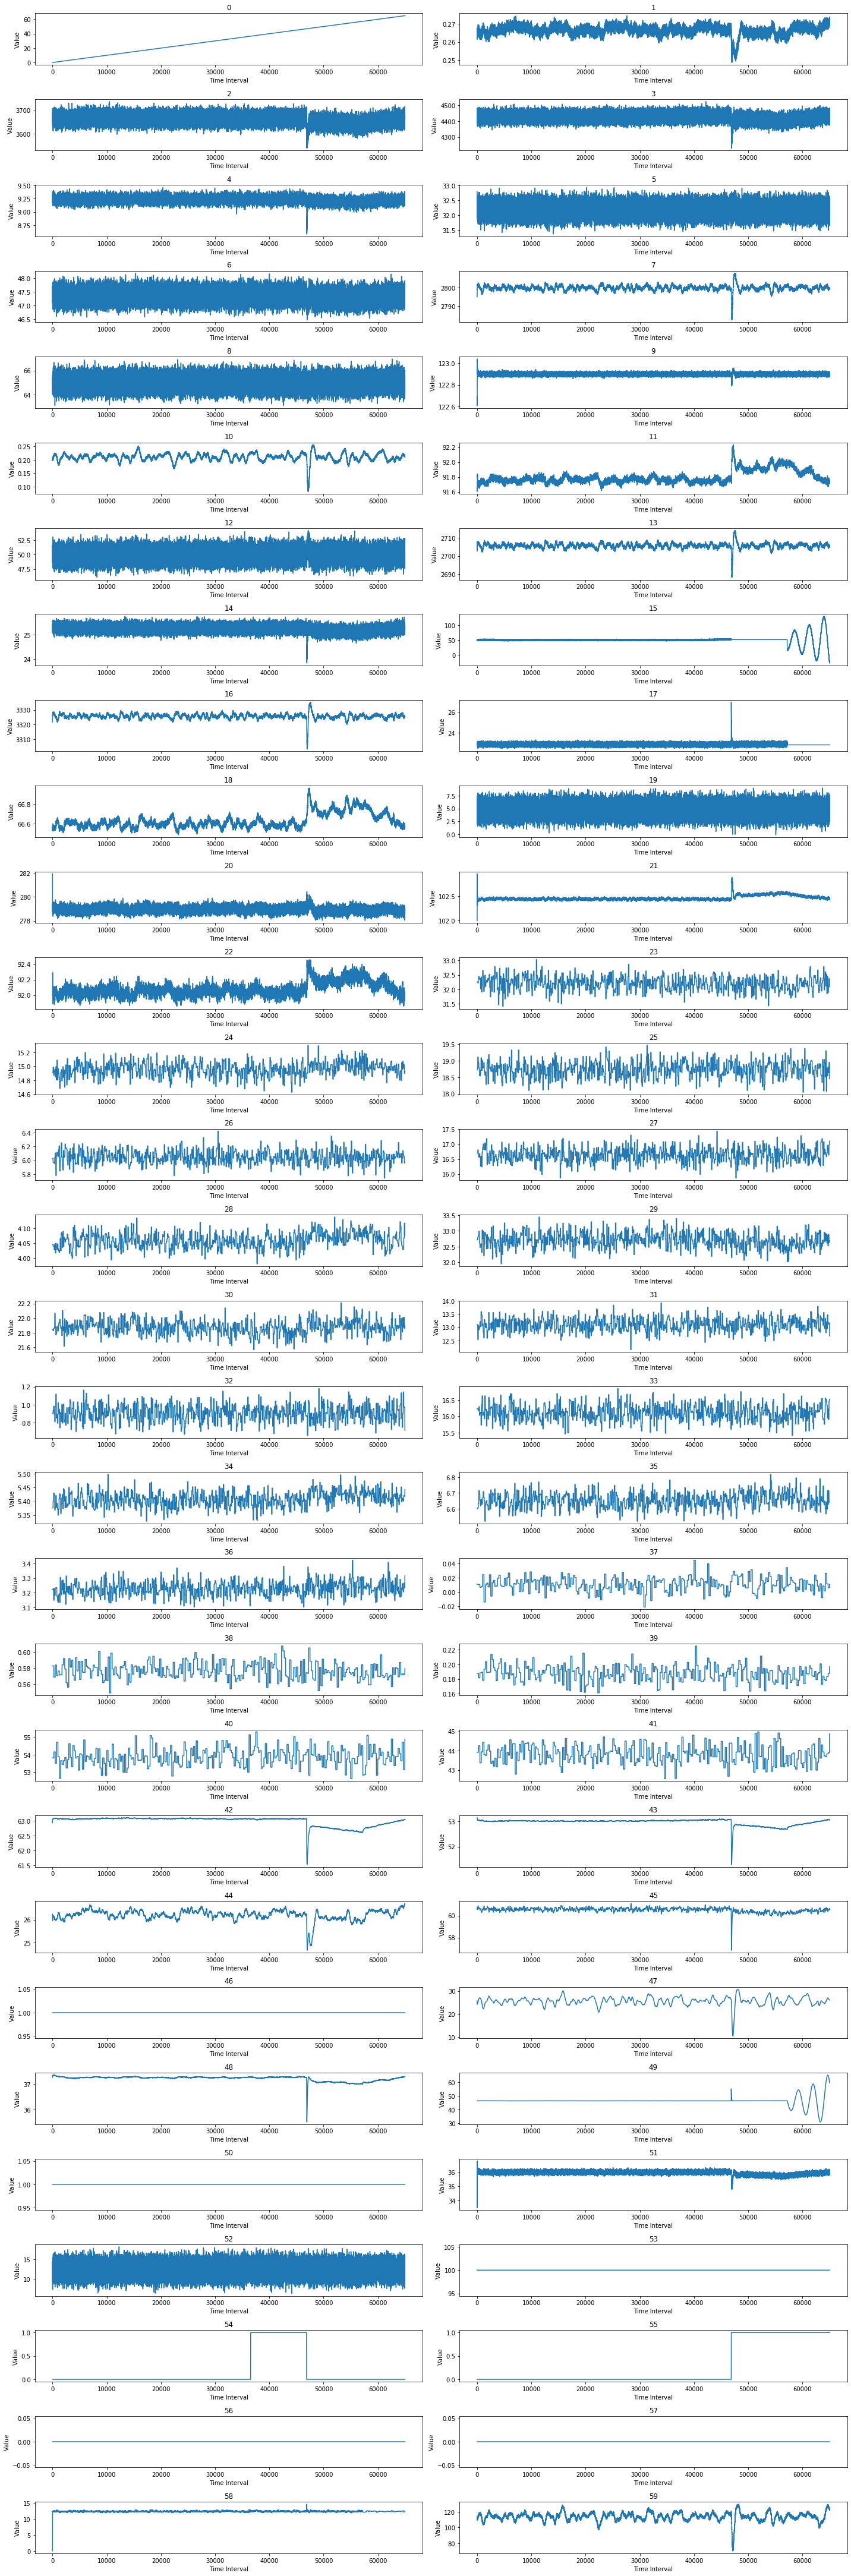

In [22]:
display_block_of_values(kaspersky_set,
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(50,2))

In [ ]:
model = Sequential()
input_layer = Input(shape=(500, 1))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2 = Conv1D(filters=64,
               kernel_size=4,
               strides=1,
               activation='relu', 
               padding='same')(conv1)
flatten_conv = TimeDistributed(Flatten())(conv2)
output_layer = GRU(2, activation="softmax", return_sequences=True)(flatten_conv)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss="binary_crossentropy", optimizer="Adam")

